In [1]:
import os

import pandas as pd

In [2]:
# filter files starting with a given prefix and ending with a given suffix
def filter_files(prefix, suffix, files):
    return [f for f in files if f.startswith(prefix) and f.endswith(suffix)]

In [3]:
results_dir = "./results/"
files = os.listdir(results_dir)
files

['results_random_forest_3ap.xlsx',
 'results_xgboost_3ap.xlsx',
 'results_mlp_3ap.xlsx',
 'results_catboost_2ap.xlsx',
 'y_2_3ap_test_pred.csv',
 'results_extra_trees_2ap.xlsx',
 'results_extra_trees_3ap.xlsx',
 'results_lightgbm_3ap.xlsx',
 'results_xgboost_2ap.xlsx',
 'results_mlp_2ap.xlsx',
 'y_2_2ap_test_pred.csv',
 'results_lightgbm_2ap.xlsx',
 'results_random_forest_2ap.xlsx',
 'results_catboost_3ap.xlsx']

In [4]:
res_3ap = filter_files("res", "_3ap.xlsx", files)
res_3ap

['results_random_forest_3ap.xlsx',
 'results_xgboost_3ap.xlsx',
 'results_mlp_3ap.xlsx',
 'results_extra_trees_3ap.xlsx',
 'results_lightgbm_3ap.xlsx',
 'results_catboost_3ap.xlsx']

In [5]:
import re


def extract_model_name(filename):
    match = re.search(r"_(\w+)_", filename)
    return match.group(1) if match else None


data_dict = {}
for f in res_3ap:
    data_dict[extract_model_name(f)] = pd.read_excel(results_dir + f, sheet_name=None)

len(data_dict)

6

In [6]:
data_dict["catboost"]["best_params"]

,Unnamed: 0,Parameter,Value,Search List
0,0,iterations,200,"[50, 100, 200]"
1,1,depth,6,"[4, 6, 8]"
2,2,learning_rate,0.2,"[0.01, 0.1, 0.2]"
3,3,l2_leaf_reg,1,"[1, 3, 5]"
4,4,loss_function,MultiClass,MultiClass
5,5,bootstrap_type,Bernoulli,"['Bernoulli', 'MVS']"


In [7]:
data_dict["catboost"]["f1"]

,Unnamed: 0,train,test
0,0,1,0.948670
1,1,1,0.816923
2,2,1,0.931021
3,3,1,0.894962
4,4,1,0.868421


In [8]:
best_mean_r2 = 0
best_model = None
best_params = None
mean_r2_dict = {}
for model, data in data_dict.items():
    mean_r2 = data["f1"]["test"].mean()
    mean_r2_dict[model] = mean_r2
    # print(f"{model}: {mean_r2}")
    if mean_r2 > best_mean_r2:
        best_mean_r2 = mean_r2
        best_model = model
        best_params = data["best_params"].set_index("Parameter")["Value"].to_dict()

mean_r2_dict

{'random_forest': 0.8946799559662726,
 'xgboost': 0.9049771760506587,
 'mlp': 0.9061308831014541,
 'extra_trees': 0.9197021302537365,
 'lightgbm': 0.9015726138162133,
 'catboost': 0.8919992921588993}

In [9]:
# mean_r2_dict["extra_trees"] = 0.81

In [10]:
for k, v in best_params.items():
    if pd.isna(v):
        best_params[k] = None

# best_params["n_estimators"] = int(best_params["n_estimators"])
# best_params["max_depth"] = int(best_params["max_depth"])

In [11]:
from modeling_old import clear_column_names


def load_data(path="./df_3ap_final.csv"):
    df = pd.read_csv(path, header=[0, 1], index_col=None)

    y = df[("mcs_nss", "_")]
    X = df.drop(columns=[("mcs_nss", "_")])

    X.columns = clear_column_names(X)

    return X, y


X, y = load_data()
X_test, y_test = load_data("./df_2_3ap_test_final.csv")
X.shape, X_test.shape

((691, 338), (87, 338))

In [12]:
from sklearn.preprocessing import LabelEncoder

# 创建 LabelEncoder 实例
le = LabelEncoder()

# 转换目标变量
y_encoded = le.fit_transform(y)

# to pd.Series
y_encoded = pd.Series(y_encoded)

In [13]:
# from modeling_old import regressor_final

# r = regressor_final(model_type=best_model, params=best_params, suffix="3ap")
# r.fit(X, y)

In [14]:
# r.plot_fit_error(X, y)

In [15]:
# all_best_params = {}
# for model, data in data_dict.items():
#     best_params = data["best_params"].set_index("Parameter")["Value"].to_dict()
#     for k, v in best_params.items():
#         if pd.isna(v):
#             best_params[k] = None
#     all_best_params[model] = best_params

# all_best_params

all_best_params = {
    "random_forest": {"n_estimators": 100, "max_features": "sqrt", "max_depth": 20},
    "xgboost": {
        "objective": "multi:softmax",
        "n_estimators": 100,
        "max_depth": 10,
        "learning_rate": 0.2,
    },
    # "mlp": {
    #     "hidden_size1": 256,
    #     "hidden_size2": 128,
    #     "weight_decay": 0.0001,
    #     "output_size": 14,
    # },
    "extra_trees": {"n_estimators": 200, "max_features": None, "max_depth": 20},
    "lightgbm": {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "n_estimators": 50,
        "learning_rate": 0.2,
        "max_depth": None,
        "num_leaves": 31,
        "min_data_in_leaf": 20,
        "feature_fraction": 0.9,
        "early_stopping_round": None,
    },
    "catboost": {
        "iterations": 200,
        "depth": 6,
        "learning_rate": 0.2,
        "l2_leaf_reg": 1,
        "loss_function": "MultiClass",
        "bootstrap_type": "Bernoulli",
    },
}

all_best_params_sorted = sorted(all_best_params.items(), key=lambda x: x[0])

best_model, all_best_params_sorted

('extra_trees',
 [('catboost',
   {'iterations': 200,
    'depth': 6,
    'learning_rate': 0.2,
    'l2_leaf_reg': 1,
    'loss_function': 'MultiClass',
    'bootstrap_type': 'Bernoulli'}),
  ('extra_trees',
   {'n_estimators': 200, 'max_features': None, 'max_depth': 20}),
  ('lightgbm',
   {'objective': 'multiclass',
    'metric': 'multi_logloss',
    'n_estimators': 50,
    'learning_rate': 0.2,
    'max_depth': None,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.9,
    'early_stopping_round': None}),
  ('random_forest',
   {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 20}),
  ('xgboost',
   {'objective': 'multi:softmax',
    'n_estimators': 100,
    'max_depth': 10,
    'learning_rate': 0.2})])

In [17]:
from modeling_old import model_selection

model, _ = model_selection(
    model_type=best_model,
    params=all_best_params[best_model],
    random_state=42,
    input_size=X.shape[1],
)

model.fit(X, y_encoded)

y_test_pred = model.predict(X_test)
y_test_pred = le.inverse_transform(y_test_pred)

# save predictions
y_test_pred = pd.Series(y_test_pred, name="mcs_nss")

df = pd.DataFrame()
df[["mcs", "nss"]] = y_test_pred.str.split("_", expand=True).astype(int)

df.to_csv("./results/y_2_3ap_test_pred.csv", index=False)

0:	learn: 2.1552155	total: 96.9ms	remaining: 19.3s
1:	learn: 1.8752256	total: 123ms	remaining: 12.2s
2:	learn: 1.7120961	total: 139ms	remaining: 9.14s
3:	learn: 1.5804937	total: 155ms	remaining: 7.59s
4:	learn: 1.4569243	total: 171ms	remaining: 6.66s
5:	learn: 1.3429334	total: 187ms	remaining: 6.04s
6:	learn: 1.2494686	total: 202ms	remaining: 5.58s
7:	learn: 1.1760389	total: 218ms	remaining: 5.24s
8:	learn: 1.1199825	total: 234ms	remaining: 4.97s
9:	learn: 1.0636577	total: 250ms	remaining: 4.75s
10:	learn: 1.0181533	total: 265ms	remaining: 4.56s
11:	learn: 0.9705944	total: 281ms	remaining: 4.4s
12:	learn: 0.9291703	total: 296ms	remaining: 4.26s
13:	learn: 0.8906009	total: 312ms	remaining: 4.15s
14:	learn: 0.8587134	total: 328ms	remaining: 4.04s
15:	learn: 0.8234886	total: 344ms	remaining: 3.95s
16:	learn: 0.7871213	total: 359ms	remaining: 3.87s
17:	learn: 0.7612858	total: 375ms	remaining: 3.79s
18:	learn: 0.7267982	total: 390ms	remaining: 3.72s
19:	learn: 0.6977748	total: 405ms	remaini

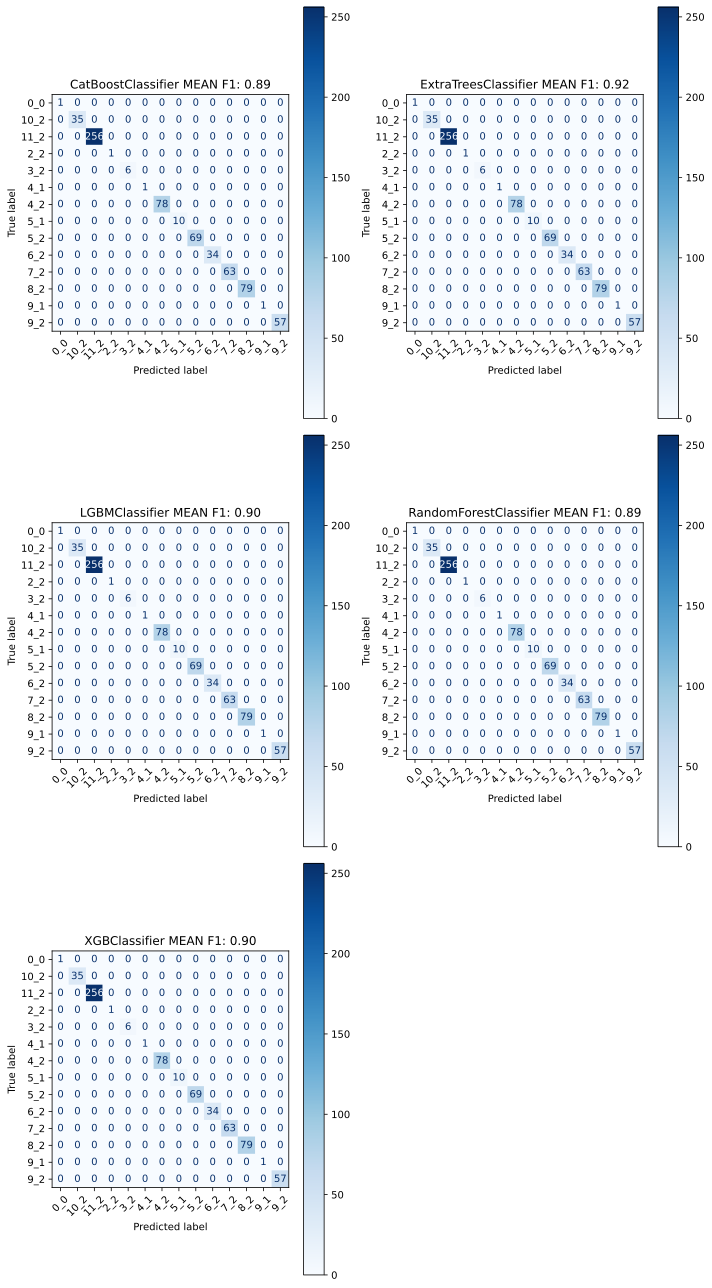

In [16]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# from matplotlib_inline import backend_inline
# from modeling_old import model_selection, process_X
# from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# backend_inline.set_matplotlib_formats("svg")

# # 设置图形的布局
# num_models = len(all_best_params)
# cols = 2  # 每行2个子图
# rows = (num_models + cols - 1) // cols  # 计算行数

# plt.figure(figsize=(10, 6 * rows))

# for i, (model_type, params) in enumerate(all_best_params_sorted):
#     model, _ = model_selection(
#         model_type=model_type, params=params, random_state=42, input_size=X.shape[1]
#     )

#     X = process_X(X, model_type=model_type)
#     model.fit(X, y_encoded)

#     y_pred = model.predict(X)

#     # 计算混淆矩阵
#     cm = confusion_matrix(y_encoded, y_pred)

#     # 创建子图
#     ax = plt.subplot(rows, cols, i + 1)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
#     disp.plot(ax=ax, cmap=plt.cm.Blues, values_format="d")

#     # 设置横轴标度旋转45度
#     plt.xticks(rotation=45)

#     ax.set_title(f"{model.__class__.__name__} MEAN F1: {mean_r2_dict[model_type]:.2f}")

# # 调整布局
# plt.tight_layout()

# # 保存图形
# plt.savefig("./fig/q2_3ap_train_confusion_matrix.svg")
# plt.show()